# 1.0 Get Data Of Stock Market

* 本篇代码用来查询所有股票数据，所有导出的数据都将导出到stockdata文件夹内，方便管理查看。
* 平台api方面，国内用tushare，国外用的雅虎。
* 本篇代码也计划用来做数据清洗并且数据展示，处理好的文件也存在stockdata文件夹里面。

In [1]:
import time

import numpy as np

print("Hello,stock market")
import pandas as pd
from datetime import datetime
start_time = datetime.now()
## todo: calculating the time of import libraries
#先引入后面分析、可视化等可能用到的库
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
#正常显示画图时出现的中文和负号
from pylab import mpl
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
# todo: solve chinese problem for plt
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

#显示所有列
# pd.set_option('display.max_columns', 100)
# #显示所有行
# pd.set_option('display.max_rows', 100)
# #设置value的显示长度为100，默认为50
# pd.set_option('max_colwidth',100)
print("Load Time: ",datetime.now()-start_time)

Hello,stock market
Load Time:  0:00:01.179881


## 1.1 use tushare api get data

In [2]:
# login tushare, use token
pro = ts.pro_api('f7b384108cbed0026a4dfa35835f75b0fb9d04673a067e8b75d8810f')


def getStockCompanyInformation(status='L', stock_code=''):
    """
    得到目前所有的股票公司信息
    :param status: 上市状态 L上市 D退市 P暂停上市，默认是L
    :param stock_code: TS股票代码
    :return:
    """

    if stock_code== '':
        rawStockCompanyDataInTushare = pro.stock_basic(exchange='', list_status=status, fields='ts_code,symbol,fullname,enname,name,area,industry,list_date')
    else:
        rawStockCompanyDataInTushare = pro.stock_basic(ts_code=stock_code, exchange='', list_status=status, fields='ts_code,symbol,fullname,enname,name,area,industry,list_date')

    rawStockCompanyDataInTushare['ts_code']=rawStockCompanyDataInTushare['ts_code'].astype(str)
    rawStockCompanyDataInTushare['symbol']=rawStockCompanyDataInTushare['symbol'].astype('float64')
    rawStockCompanyDataInTushare['name']=rawStockCompanyDataInTushare['name'].astype(str)
    rawStockCompanyDataInTushare['area']=rawStockCompanyDataInTushare['area'].astype(str)
    rawStockCompanyDataInTushare['industry']=rawStockCompanyDataInTushare['industry'].astype(str)
    rawStockCompanyDataInTushare['fullname']=rawStockCompanyDataInTushare['fullname'].astype(str)
    rawStockCompanyDataInTushare['enname']=rawStockCompanyDataInTushare['enname'].astype(str)
    rawStockCompanyDataInTushare['list_date']=rawStockCompanyDataInTushare['list_date'].astype('float64')

    rawStockCompanyDataInTushare['list_date']=pd.to_datetime(rawStockCompanyDataInTushare['list_date'], format='%Y%m%d')
    return rawStockCompanyDataInTushare


# 拉取数据
def getDailyStockData(stock_code="",start="20180101",end="20230101"):
    """
    拉取股票日结交易信息，时间段默认 2018-1-1 到 2022-1-1，注意：该函数单次只能查询6000条记录。
    :param stock_code: 股票代码，默认为空，输入为空的时候，拉取这段时期所有股票的交易消息；若不为空，拉去这只股票这段时间的交易消息
    :param start: 开始日期
    :param end: 结束日期
    :return:
    """
    rawData = pro.daily(**{
        "ts_code": stock_code,
        "trade_date": "",
        "start_date": start,
        "end_date": end,
        "offset": "",
        "limit": "",
    }, fields=[
        "ts_code",
        "trade_date",
        "open",
        "high",
        "low",
        "close",
        "pre_close",
        "change",
        "pct_chg",
        "vol",
        "amount"
    ])
    rawData['ts_code']=rawData['ts_code'].astype(str)
    rawData['trade_date']=rawData['trade_date'].astype('float64')

    rawData['trade_date']=pd.to_datetime(rawData['trade_date'], format='%Y%m%d')
    return rawData


In [3]:
rawCompanyDataInTushare=getStockCompanyInformation()
print("The shape of the data frame: {}".format(rawCompanyDataInTushare.shape))
print("The types in the data frame {}".format(rawCompanyDataInTushare.dtypes))
rawCompanyDataInTushare

The shape of the data frame: (5168, 8)
The types in the data frame ts_code              object
symbol              float64
name                 object
area                 object
industry             object
fullname             object
enname               object
list_date    datetime64[ns]
dtype: object


,ts_code,symbol,name,area,industry,fullname,enname,list_date
0,000001.SZ,1.0,平安银行,深圳,银行,平安银行股份有限公司,"Ping An Bank Co., Ltd.",1991-04-03
1,000002.SZ,2.0,万科A,深圳,全国地产,万科企业股份有限公司,"China Vanke Co.,Ltd.",1991-01-29
2,000004.SZ,4.0,ST国华,深圳,软件服务,深圳国华网安科技股份有限公司,Shenzhen Guohua Network Security Technology Co...,1991-01-14
3,000005.SZ,5.0,ST星源,深圳,环境保护,深圳世纪星源股份有限公司,Shenzhen Fountain Corporation,1990-12-10
4,000006.SZ,6.0,深振业A,深圳,区域地产,深圳市振业(集团)股份有限公司,"Shenzhen Zhenye(Group) Co., Ltd",1992-04-27
...,...,...,...,...,...,...,...,...
5163,873305.BJ,873305.0,九菱科技,None,None,荆州九菱科技股份有限公司,"Jingzhou Julin Science And Technology Co.,Ltd",2022-12-21
5164,873339.BJ,873339.0,恒太照明,None,None,江苏恒太照明股份有限公司,"Jiangsu Ever-Tie Lighting Co., Ltd",2022-11-17
5165,873527.BJ,873527.0,夜光明,None,None,浙江夜光明光电科技股份有限公司,"Zhejiang Ygm Technology Co.,Ltd",2022-10-27
5166,873593.BJ,873593.0,鼎智科技,None,None,江苏鼎智智能控制科技股份有限公司,Jiangsu DINGS Intelligent Control Technology C...,2023-04-13


In [4]:
rawDailyDataInTushare=getDailyStockData()
print("The shape of the data frame: {}".format(rawDailyDataInTushare.shape))
print("The types in the data frame:\n{}".format(rawDailyDataInTushare.dtypes))
print("The unique stock code: {}".format(len(rawDailyDataInTushare['ts_code'].unique())))
rawDailyDataInTushare

The shape of the data frame: (6000, 11)
The types in the data frame:
ts_code               object
trade_date    datetime64[ns]
open                 float64
high                 float64
low                  float64
close                float64
pre_close            float64
change               float64
pct_chg              float64
vol                  float64
amount               float64
dtype: object
The unique stock code: 5061


,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,002198.SZ,2022-12-30,6.39,6.57,6.33,6.52,6.40,0.12,1.8750,101579.12,65646.164
1,002199.SZ,2022-12-30,6.36,6.43,6.28,6.39,6.29,0.10,1.5898,38684.00,24640.014
2,002194.SZ,2022-12-30,9.13,9.26,9.07,9.21,9.10,0.11,1.2088,101101.41,92895.425
3,002181.SZ,2022-12-30,5.28,5.52,5.28,5.46,5.31,0.15,2.8249,547665.70,297495.407
4,002195.SZ,2022-12-30,1.99,2.02,1.98,2.01,1.98,0.03,1.5152,444728.72,89088.620
...,...,...,...,...,...,...,...,...,...,...,...
5995,300185.SZ,2022-12-29,2.43,2.43,2.38,2.39,2.43,-0.04,-1.6461,169697.00,40744.559
5996,002212.SZ,2022-12-29,9.51,9.93,9.48,9.85,9.59,0.26,2.7112,166568.42,163068.690
5997,002213.SZ,2022-12-29,16.37,16.37,15.61,15.68,14.88,0.80,5.3763,238641.86,386408.221
5998,002397.SZ,2022-12-29,4.54,4.67,4.51,4.54,4.60,-0.06,-1.3043,127870.79,58483.435


In [5]:
##test
testDailyStockData=getDailyStockData(stock_code="000006.SZ")
testDailyStockData

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000006.SZ,2022-12-30,6.29,6.46,6.21,6.30,6.13,0.17,2.7732,1280164.06,807162.552
1,000006.SZ,2022-12-29,6.60,6.65,6.13,6.13,6.81,-0.68,-9.9853,2067778.94,1305956.659
2,000006.SZ,2022-12-28,6.47,7.17,6.40,6.81,6.64,0.17,2.5602,2646897.32,1789639.303
3,000006.SZ,2022-12-27,6.00,6.64,5.96,6.64,6.04,0.60,9.9338,2469265.08,1612828.768
4,000006.SZ,2022-12-26,5.69,6.18,5.65,6.04,5.91,0.13,2.1997,1502166.93,894013.083
...,...,...,...,...,...,...,...,...,...,...,...
1168,000006.SZ,2018-03-14,8.55,8.65,8.28,8.29,8.70,-0.41,-4.7100,596514.45,502396.942
1169,000006.SZ,2018-03-13,8.65,8.88,8.60,8.70,8.65,0.05,0.5800,607777.85,530832.951
1170,000006.SZ,2018-03-12,8.61,8.79,8.49,8.65,8.80,-0.15,-1.7000,738316.89,635967.707
1171,000006.SZ,2018-03-09,8.61,9.23,8.44,8.80,8.87,-0.07,-0.7900,1119431.92,971167.257


In [6]:
###由于Toshare社区限制每次查询只能拿到 6000 行日结交易信息（每日每公司为一行），而且每分钟只能查500次。为了得到当前所有上市公司，每次查询只查一家上市公司而且将会延迟0.2秒
def bindDailyAndCompanyInformation():
    notIncludedData=['name']

    startTime=datetime.now()
    companies=getStockCompanyInformation()
    bindData=pd.DataFrame()
    i=2
    for company in companies['ts_code'].to_numpy():
        dailyData=getDailyStockData(stock_code=company)
        for header in companies.columns:
            if header!="ts_code":
                #test only
                # print("------------------------------------")
                # print(companies[companies['ts_code'] == company][header].values.repeat(5))
                # print(dailyData.shape[0])
                # print("------------------------------------")
                dailyData[header]= companies[companies['ts_code'] == company][header].values.repeat(dailyData.shape[0])

        dailyData=dailyData.drop(columns=notIncludedData)
        bindData=bindData.append(dailyData)
        #time.sleep(0.15)
        ###########test only
        #print(dailyData)
        # if i==1:
        #     break
        # else:
        #     i-=1
        ###########
    timeConsume=datetime.now()-startTime;
    print("Run time: {}".format(timeConsume))
    return bindData


In [7]:
###此cell仅用于下载股票数据，由于信息量庞大，可导入下好的 TushareRawData.csv 文件即可
# theBindDataInTushare=bindDailyAndCompanyInformation()
# print("The shape of the data frame: {}".format(theBindDataInTushare.shape))
# print("The types in the data frame:\n{}".format(theBindDataInTushare.dtypes))
# print("The unique stock code: {}".format(len(theBindDataInTushare['ts_code'].unique())))
# theBindDataInTushare.to_csv('stockData/TushareRawData.csv', header=theBindDataInTushare.columns, index=False)

In [8]:
###此cell是本地读取tushare股票信息，如果本地有csv文件就用这个，并且注释上一个cell，如果没下载csv文件就取消注释上一个cell
theBindDataInTushare=pd.read_csv('stockData/TushareRawData.csv')
print("The shape of the data frame: {}".format(theBindDataInTushare.shape))
print("The types in the data frame:\n{}".format(theBindDataInTushare.dtypes))
print("The unique stock code: {}".format(len(theBindDataInTushare['ts_code'].unique())))

The shape of the data frame: (4808334, 17)
The types in the data frame:
ts_code        object
trade_date     object
open          float64
high          float64
low           float64
close         float64
pre_close     float64
change        float64
pct_chg       float64
vol           float64
amount        float64
symbol        float64
area           object
industry       object
fullname       object
enname         object
list_date      object
dtype: object
The unique stock code: 5061


In [9]:
###不知道为什么有100家公司查不到，手动查询看看情况，然后手动合并吧
missedCompany=[]
bindCompany=theBindDataInTushare['ts_code'].unique()
for code in rawCompanyDataInTushare['ts_code'].values:
    if code not in bindCompany:
        missedCompany.append(code)


# for code in missedCompany:
#     print("-------------------------------------")
#     print(getDailyStockData(stock_code=code,end="20220505"))
#     print(getStockCompanyInformation(stock_code=code))
#     print("-------------------------------------")

print("The num of miss company: {}".format(len(missedCompany)))

###这些股票查不到，这些公司基本都是2023年上市的，可能数据还没更新吧

The num of miss company: 107


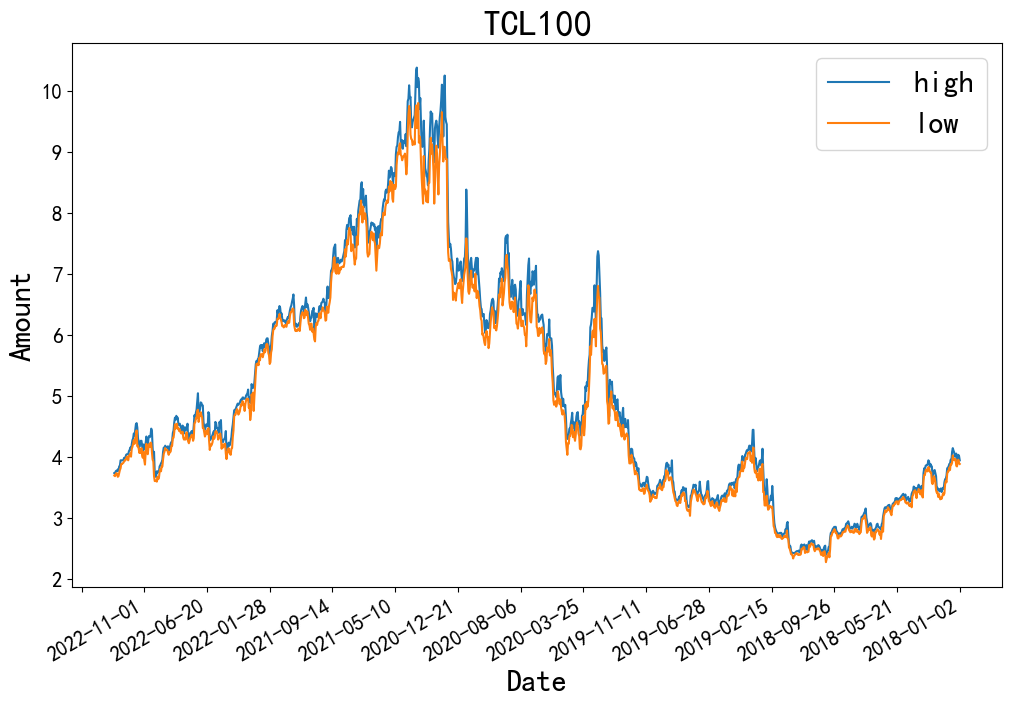

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,symbol,area,industry,fullname,enname,list_date
68765,000100.SZ,2022-12-30,3.71,3.73,3.69,3.72,3.70,0.02,0.5405,746469.94,277090.833,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
68766,000100.SZ,2022-12-29,3.72,3.73,3.68,3.70,3.73,-0.03,-0.8043,839641.79,310683.418,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
68767,000100.SZ,2022-12-28,3.75,3.76,3.71,3.73,3.75,-0.02,-0.5333,690095.26,257697.493,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
68768,000100.SZ,2022-12-27,3.76,3.77,3.73,3.75,3.75,0.00,0.0000,514072.58,192359.193,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
68769,000100.SZ,2022-12-26,3.72,3.76,3.72,3.75,3.73,0.02,0.5362,533547.21,199601.121,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69974,000100.SZ,2018-01-08,3.92,3.93,3.84,3.88,3.92,-0.04,-1.0200,1195519.87,463110.265,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
69975,000100.SZ,2018-01-05,3.97,3.97,3.90,3.92,3.96,-0.04,-1.0100,895278.01,351262.479,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
69976,000100.SZ,2018-01-04,3.98,4.03,3.95,3.96,3.99,-0.03,-0.7500,931098.87,370750.903,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
69977,000100.SZ,2018-01-03,3.90,4.01,3.89,3.99,3.91,0.08,2.0500,1460967.32,578296.762,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30


In [22]:
TCLStock=theBindDataInTushare[theBindDataInTushare['ts_code']=="000100.SZ"]
plt.figure(figsize=(12,8))
ax = plt.gca()
locator = mdates.DayLocator(interval=30*3)
ax.xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.plot(TCLStock['trade_date'],TCLStock['high'],label="high")
plt.plot(TCLStock['trade_date'],TCLStock['low'],label="low")
plt.xlabel("Date")
plt.ylabel("Amount")
plt.title('TCL100')
plt.legend()   #打上标签
plt.show()
TCLStock

## 1.2 use yfinance (雅虎非官方API) api get stock data

In [11]:
#测试api
data = yf.download(tickers='AMD',start='2018-01-1',end='2023-01-01')
print("The types in the data frame:\n{}".format(data.dtypes))
data

[*********************100%***********************]  1 of 1 completed
The types in the data frame:
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,10.420000,11.020000,10.340000,10.980000,10.980000,44146300
2018-01-03,11.610000,12.140000,11.360000,11.550000,11.550000,154066700
2018-01-04,12.100000,12.430000,11.970000,12.120000,12.120000,109503000
2018-01-05,12.190000,12.220000,11.660000,11.880000,11.880000,63808900
2018-01-08,12.010000,12.300000,11.850000,12.280000,12.280000,63346000
...,...,...,...,...,...,...
2022-12-23,63.110001,64.660004,62.720001,64.519997,64.519997,45923000
2022-12-27,63.869999,64.279999,62.970001,63.270000,63.270000,36086000
2022-12-28,62.540001,63.540001,61.959999,62.570000,62.570000,39526500


In [12]:
amd = yf.Ticker("AMD")
info=pd.DataFrame.from_dict(amd.info)
print("The types in the data frame:\n{}".format(info.dtypes))
info

The types in the data frame:
address1              object
city                  object
state                 object
zip                   object
country               object
                      ...   
grossMargins         float64
ebitdaMargins        float64
operatingMargins     float64
financialCurrency     object
trailingPegRatio     float64
Length: 103, dtype: object


,address1,city,state,zip,country,phone,website,industry,industryDisp,sector,...,recommendationMean,recommendationKey,numberOfAnalystOpinions,revenuePerShare,grossProfits,grossMargins,ebitdaMargins,operatingMargins,financialCurrency,trailingPegRatio
0,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,2.1,buy,35,15.119,12051000000,0.0,0.0,0.0,USD,1.5936
1,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,2.1,buy,35,15.119,12051000000,0.0,0.0,0.0,USD,1.5936
2,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,2.1,buy,35,15.119,12051000000,0.0,0.0,0.0,USD,1.5936
3,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,2.1,buy,35,15.119,12051000000,0.0,0.0,0.0,USD,1.5936
4,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,2.1,buy,35,15.119,12051000000,0.0,0.0,0.0,USD,1.5936
5,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,2.1,buy,35,15.119,12051000000,0.0,0.0,0.0,USD,1.5936
6,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,2.1,buy,35,15.119,12051000000,0.0,0.0,0.0,USD,1.5936
7,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,2.1,buy,35,15.119,12051000000,0.0,0.0,0.0,USD,1.5936
8,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,2.1,buy,35,15.119,12051000000,0.0,0.0,0.0,USD,1.5936
9,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,2.1,buy,35,15.119,12051000000,0.0,0.0,0.0,USD,1.5936


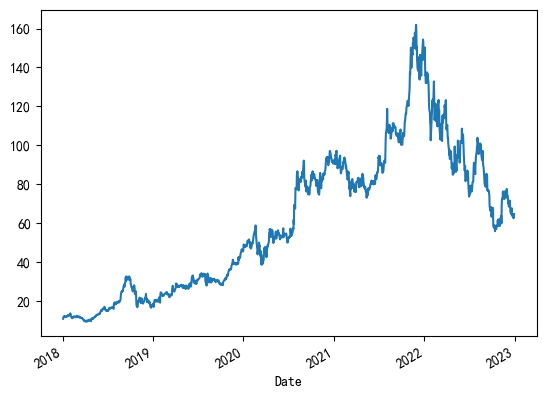

In [13]:
data["Close"].plot()
plt.show()

In [14]:
##获取标普500股票公司名字
import bs4 as bs
import requests

###爬取维基百科标普500公司名称
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

###筛选元素
tickers = []
for row in table.findAll('tr')[1:]:
   ticker = row.findAll('td')[0].text
   ticker=ticker.replace("\n","")
   tickers.append(ticker)


tickers

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ATVI',
 'ADM',
 'ADBE',
 'ADP',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AMD',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BBWI',
 'BAX',
 'BDX',
 'WRB',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BG',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CDAY',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',

In [15]:
def getStockDataInYFinance(name,start='2018-01-1',end='2023-01-01'):
    includedList=['country','zip','industry','sector']
    data = yf.download(tickers=name,start=start,end=end)
    data['trade_date'] = data.index
    company = yf.Ticker(name)
    try:
        companyInfo=pd.DataFrame.from_dict(company.info)
    except BaseException:
        print(company.info)
        return np.nan
    else:
        data['name']=[name]*data.shape[0]
        for column in companyInfo.columns:
            if column in includedList:
                data[column]=np.array([companyInfo[column].values[0]]).repeat(data.shape[0])

    return data


### get all stock data and store them
def storeAllStockDataForYFinance():
    now=datetime.now()
    allStockDataInYFinance=pd.DataFrame()
    for company in tickers:
        companyInfo=getStockDataInYFinance(company)
        if companyInfo is np.nan:
            print("break, company {} data is null")
            continue
        else:
            allStockDataInYFinance=allStockDataInYFinance.append(companyInfo)
    print("Cost time: {}".format(datetime.now()-now))
    return allStockDataInYFinance

In [16]:
getStockDataInYFinance(tickers[0]).dtypes

[*********************100%***********************]  1 of 1 completed


Open                 float64
High                 float64
Low                  float64
Close                float64
Adj Close            float64
Volume                 int64
trade_date    datetime64[ns]
name                  object
zip                   object
country               object
industry              object
sector                object
dtype: object

In [17]:
###仅用于下载yfinance 股票数据
# stockDataInYFinance=storeAllStockDataForYFinance()
# stockDataInYFinance.to_csv('stockData/YFinanceRawData.csv', header=stockDataInYFinance.columns,index=False)

In [18]:
###验证一下有多少个查漏了
stockDataInYFinance=pd.read_csv('stockData/YFinanceRawData.csv')
uniqueCompany=stockDataInYFinance['name'].unique()
missedList=[]
for ticker in tickers:
    if ticker not in uniqueCompany:
        missedList.append(ticker)

print("length of miss company: {}".format(len(missedList)))
###总共有3个公司遗漏

###手动查询
for company in missedList:
    print("------------------------------------------------------")
    print("This is the information for {}".format(company))
    print(getStockDataInYFinance(name=company))
    print("------------------------------------------------------")
###经过调查，属于信息不完善，有的连公司信息都不全

length of miss company: 3
------------------------------------------------------
This is the information for BRK.B
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BRK.B: No timezone found, symbol may be delisted
{'maxAge': 86400, 'priceHint': 2, 'quoteType': 'EQUITY', 'symbol': 'BRK.B', 'underlyingSymbol': 'BRK.B', 'uuid': '5a2c1675-19de-345f-a8c3-a61c958d64f1', 'trailingPegRatio': None}
nan
------------------------------------------------------
------------------------------------------------------
This is the information for BF.B
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted
{'exchange': 'YHD', 'quoteType': 'MUTUALFUND', 'symbol': 'BF.B', 'underlyingSymbol': 'BF.B', 'timeZoneFullName': 'America/New_York', 'timeZoneShortName': 'EDT', 'uuid': '69748612-d5d0-36f5-be88-ea00a370321d', 'gmtOffSetMilliseconds': -14400000, 'maxAge': 86400, 't

In [19]:
print("types in data: {}".format(stockDataInYFinance.dtypes))
stockDataInYFinance

types in data: Open          float64
High          float64
Low           float64
Close         float64
Adj Close     float64
Volume          int64
trade_date     object
name           object
zip            object
country        object
industry       object
sector         object
dtype: object


,Open,High,Low,Close,Adj Close,Volume,trade_date,name,zip,country,industry,sector
0,235.779999,237.070007,232.809998,235.639999,196.467621,2931000,2018-01-02,MMM,55144-1000,United States,Conglomerates,Industrials
1,235.070007,235.729996,233.289993,235.630005,196.459274,2193700,2018-01-03,MMM,55144-1000,United States,Conglomerates,Industrials
2,237.000000,239.440002,236.470001,238.710007,199.027298,2243100,2018-01-04,MMM,55144-1000,United States,Conglomerates,Industrials
3,238.649994,240.899994,237.740005,240.570007,200.578079,1835900,2018-01-05,MMM,55144-1000,United States,Conglomerates,Industrials
4,239.380005,240.940002,239.179993,239.789993,199.927704,1869000,2018-01-08,MMM,55144-1000,United States,Conglomerates,Industrials
...,...,...,...,...,...,...,...,...,...,...,...,...
623702,144.509995,145.889999,143.539993,145.759995,145.106659,1017900,2022-12-23,ZTS,07054,United States,Drug Manufacturers—Specialty & Generic,Healthcare
623703,145.910004,146.149994,143.570007,145.300003,144.648743,957900,2022-12-27,ZTS,07054,United States,Drug Manufacturers—Specialty & Generic,Healthcare
623704,145.179993,146.639999,143.770004,143.830002,143.185318,1443900,2022-12-28,ZTS,07054,United States,Drug Manufacturers—Specialty & Generic,Healthcare
623705,145.199997,148.509995,145.139999,148.149994,147.485947,1298900,2022-12-29,ZTS,07054,United States,Drug Manufacturers—Specialty & Generic,Healthcare


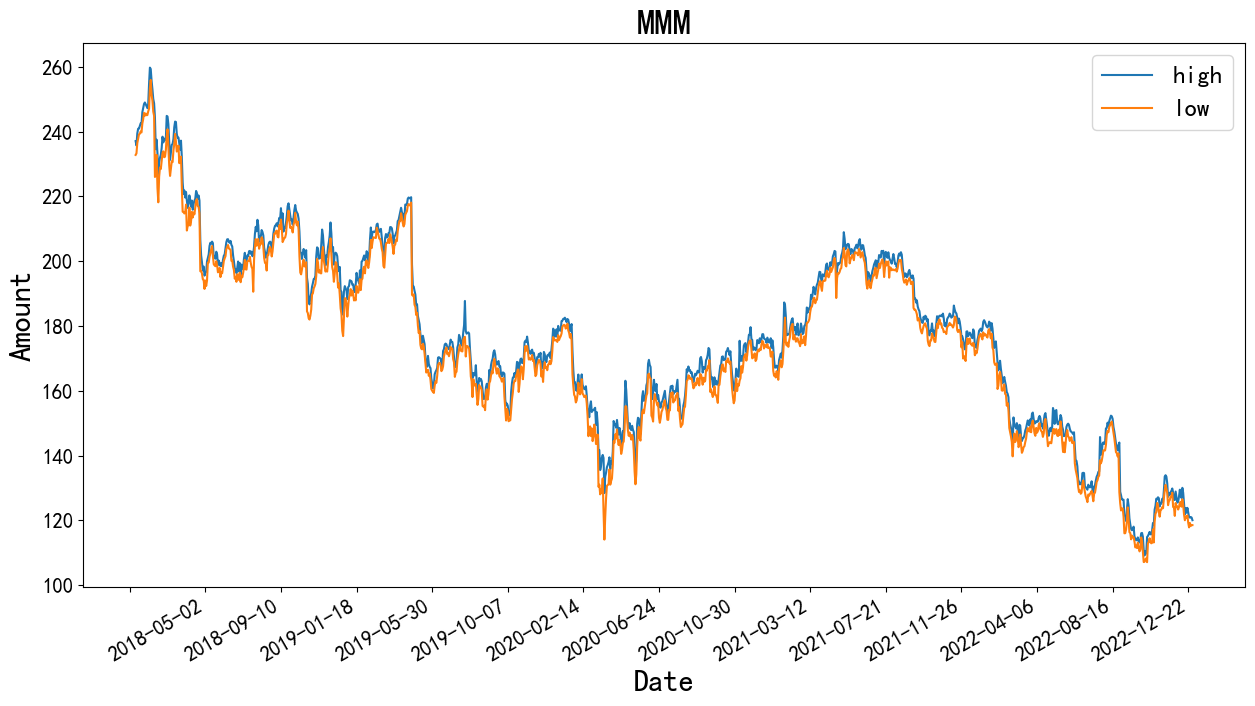

,Open,High,Low,Close,Adj Close,Volume,trade_date,name,zip,country,industry,sector
0,235.779999,237.070007,232.809998,235.639999,196.467621,2931000,2018-01-02,MMM,55144-1000,United States,Conglomerates,Industrials
1,235.070007,235.729996,233.289993,235.630005,196.459274,2193700,2018-01-03,MMM,55144-1000,United States,Conglomerates,Industrials
2,237.000000,239.440002,236.470001,238.710007,199.027298,2243100,2018-01-04,MMM,55144-1000,United States,Conglomerates,Industrials
3,238.649994,240.899994,237.740005,240.570007,200.578079,1835900,2018-01-05,MMM,55144-1000,United States,Conglomerates,Industrials
4,239.380005,240.940002,239.179993,239.789993,199.927704,1869000,2018-01-08,MMM,55144-1000,United States,Conglomerates,Industrials
...,...,...,...,...,...,...,...,...,...,...,...,...
1254,120.790001,121.000000,117.800003,120.139999,118.570084,2609300,2022-12-23,MMM,55144-1000,United States,Conglomerates,Industrials
1255,120.139999,120.830002,119.160004,120.220001,118.649040,1811200,2022-12-27,MMM,55144-1000,United States,Conglomerates,Industrials
1256,120.349998,121.000000,118.250000,118.290001,116.744263,1961000,2022-12-28,MMM,55144-1000,United States,Conglomerates,Industrials
1257,118.870003,120.860001,118.500000,120.570000,118.994469,2060800,2022-12-29,MMM,55144-1000,United States,Conglomerates,Industrials


In [23]:
MMMStock=stockDataInYFinance[stockDataInYFinance['name']=="MMM"]

plt.figure(figsize=(15,8))

ax = plt.gca()
locator = mdates.DayLocator(interval=30*3)
ax.xaxis.set_major_locator(locator)

x=MMMStock['trade_date']

plt.plot(x,MMMStock['High'],label="high")
plt.plot(x,MMMStock['Low'],label="low")
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Amount")
plt.title('MMM')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams.update({'font.size': 18})
plt.legend()   #打上标签
plt.show()
MMMStock